### Hello, in this notebook I will be showcasing 3 skills:###
1. scraping a website
2. Performing NLP on the content
3. using the NLP analysis to predict/ classify the origin of the content

Specifically, I will be scraping two popular subreddits, /r/Futurology and /r/AskScience. They are similar enough to present an interesting challenge, but different enough so that our human intuition can guide our thinking about our ML results. I hypothesize: 

- While Futurology undoubtedly will talk a lot about science and engineering, it is bound to have non-sci/tech topics as well. 
- AskScience will have more technical words, perhaps longer posts/comments as people explain concepts

In [136]:
import requests, json, time
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

# EDA Stuff #
# lets start with naming our urls
fut_url= "https://www.reddit.com/r/Futurology/"
sci_url = "https://www.reddit.com/r/askscience/"

res = requests.get(sci_url+'top.json?t=all', headers={'User-agent': 'Foo Bar 1.0'})

# Interesting properties in 'data' are 
# num_comments, title, selftext, and upvotes
res.json()["data"]['children']

# This function gets a subreddit name and scrapes the top thousand entries in JSON, returning a list of them
def scrape_subr(subr):
    url= "https://www.reddit.com/r/"+subr+'/top.json?t=all'; 
    posts=[];
    after= None; 
    
    for _ in range(40):
            if after == None:
                current_url = url
            else:
                current_url = url + '&after=' + after
            print(f'Page {_}:', current_url);

            #make the request and handle status code, add 1 sec sleep

            res= requests.get(current_url, headers={'User-agent': 'DataSci 4.5'})

            if res.status_code != 200:
                print('Status error', res.status_code)
                break

            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']]
            posts.extend(current_posts)

            after= current_dict['data']['after']

            time.sleep(2)
    return posts


sci_posts= scrape_subr('AskScience')

sci_posts[0]

sci_df= pd.DataFrame(sci_posts)

sci_df.to_csv('./data_csvs/raw_sci.csv')

sci_clean= sci_df[['title', 'ups', 'selftext', 'num_comments', 'subreddit']]

sci_clean.to_csv('./data_csvs/clean_sci.csv')

# turn this process into a function
def clean_subr_df(posts):
    df = pd.DataFrame(posts)
    cleandf = df[['title', 'ups', 'selftext', 'num_comments', 'subreddit']]
    return cleandf

fut_posts = scrape_subr('Futurology')

clean_fut_df = clean_subr_df(fut_posts)

clean_fut_df.to_csv('./data_csvs/clean_fut.csv')

In [83]:
# master_df = pd.concat([sci_clean, clean_fut_df])
##RIght here if starting anew:
sci_df = pd.read_csv('./data_csvs/clean_sci.csv')
fut_df = pd.read_csv('./data_csvs/clean_fut.csv')
master_df = pd.concat([sci_df, fut_df])
#Drop the extraneous index column
master_df.drop('Unnamed: 0', 1, inplace=True)

In [84]:
#gonna map the subreddit to a 1 if 'askcience', 0 otherwise
map_dict= {
    "askscience": 1,
    "Futurology": 0
}
master_df['subreddit'] = master_df['subreddit'].map(map_dict)

In [85]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [86]:
from collections import Counter 

from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech

wnl= WordNetLemmatizer()

In [1]:
#courtesy of https://rustyonrampage.github.io/text-mining/2017/11/23/stemming-and-lemmatization-with-python-and-nltk.html
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

In [88]:
# I'm going to stem / lemmatize 
corpus = list(master_df['title'])
lem_corp = [];
for t in corpus:
    new_t = " ".join([wnl.lemmatize(w, pos=get_pos(w)) for w in t.split()])
    lem_corp.append(new_t)
vec_raw = tfidf.fit_transform(lem_corp)

In [89]:
vec_df = pd.DataFrame(vec_raw.toarray(), columns = tfidf.get_feature_names())

In [90]:
#prefix column names with "data_" in case they correspond with word vectors
master_df.columns = ["data_" + col for col in master_df.columns]

In [91]:
df = pd.concat([master_df.reset_index(drop=True)
                .drop(columns=['data_selftext','data_title']), vec_df], axis=1)

In [92]:
X= df.drop(columns='data_subreddit')
y = df['data_subreddit']

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

NameError: name 'train_test_split' is not defined

In [94]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_train, y_train)

1.0

In [95]:
dtr.score(X_test, y_test)

0.4537493158182814

^^ This is very overfit. Let's get some more info on our model:

In [96]:
# The depth is too much,
dtr.tree_.max_depth, dtr.tree_.n_features, dtr.get_params()

(42,
 6071,
 {'criterion': 'mse',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'presort': False,
  'random_state': None,
  'splitter': 'best'})

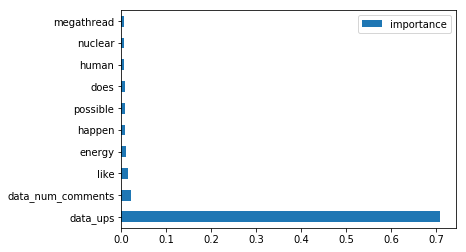

In [97]:
feat_importance = pd.DataFrame(dtr.feature_importances_, X.columns, columns = ['importance'])

feat_importance.sort_values('importance', ascending=False).head(10).plot(kind='barh')

^^ From the above bar plot we se that the top three features have to do with the popularity of the post (ups and comments) and the word "does" (makes sense for something called "ask science")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2bbccb048>,
      dtype=object)

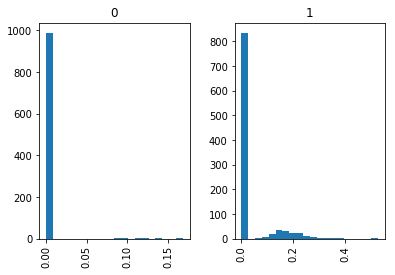

In [43]:
# df.groupby('data_subreddit')['does'].hist()
df['does'].hist(by= df['data_subreddit'], bins=20)

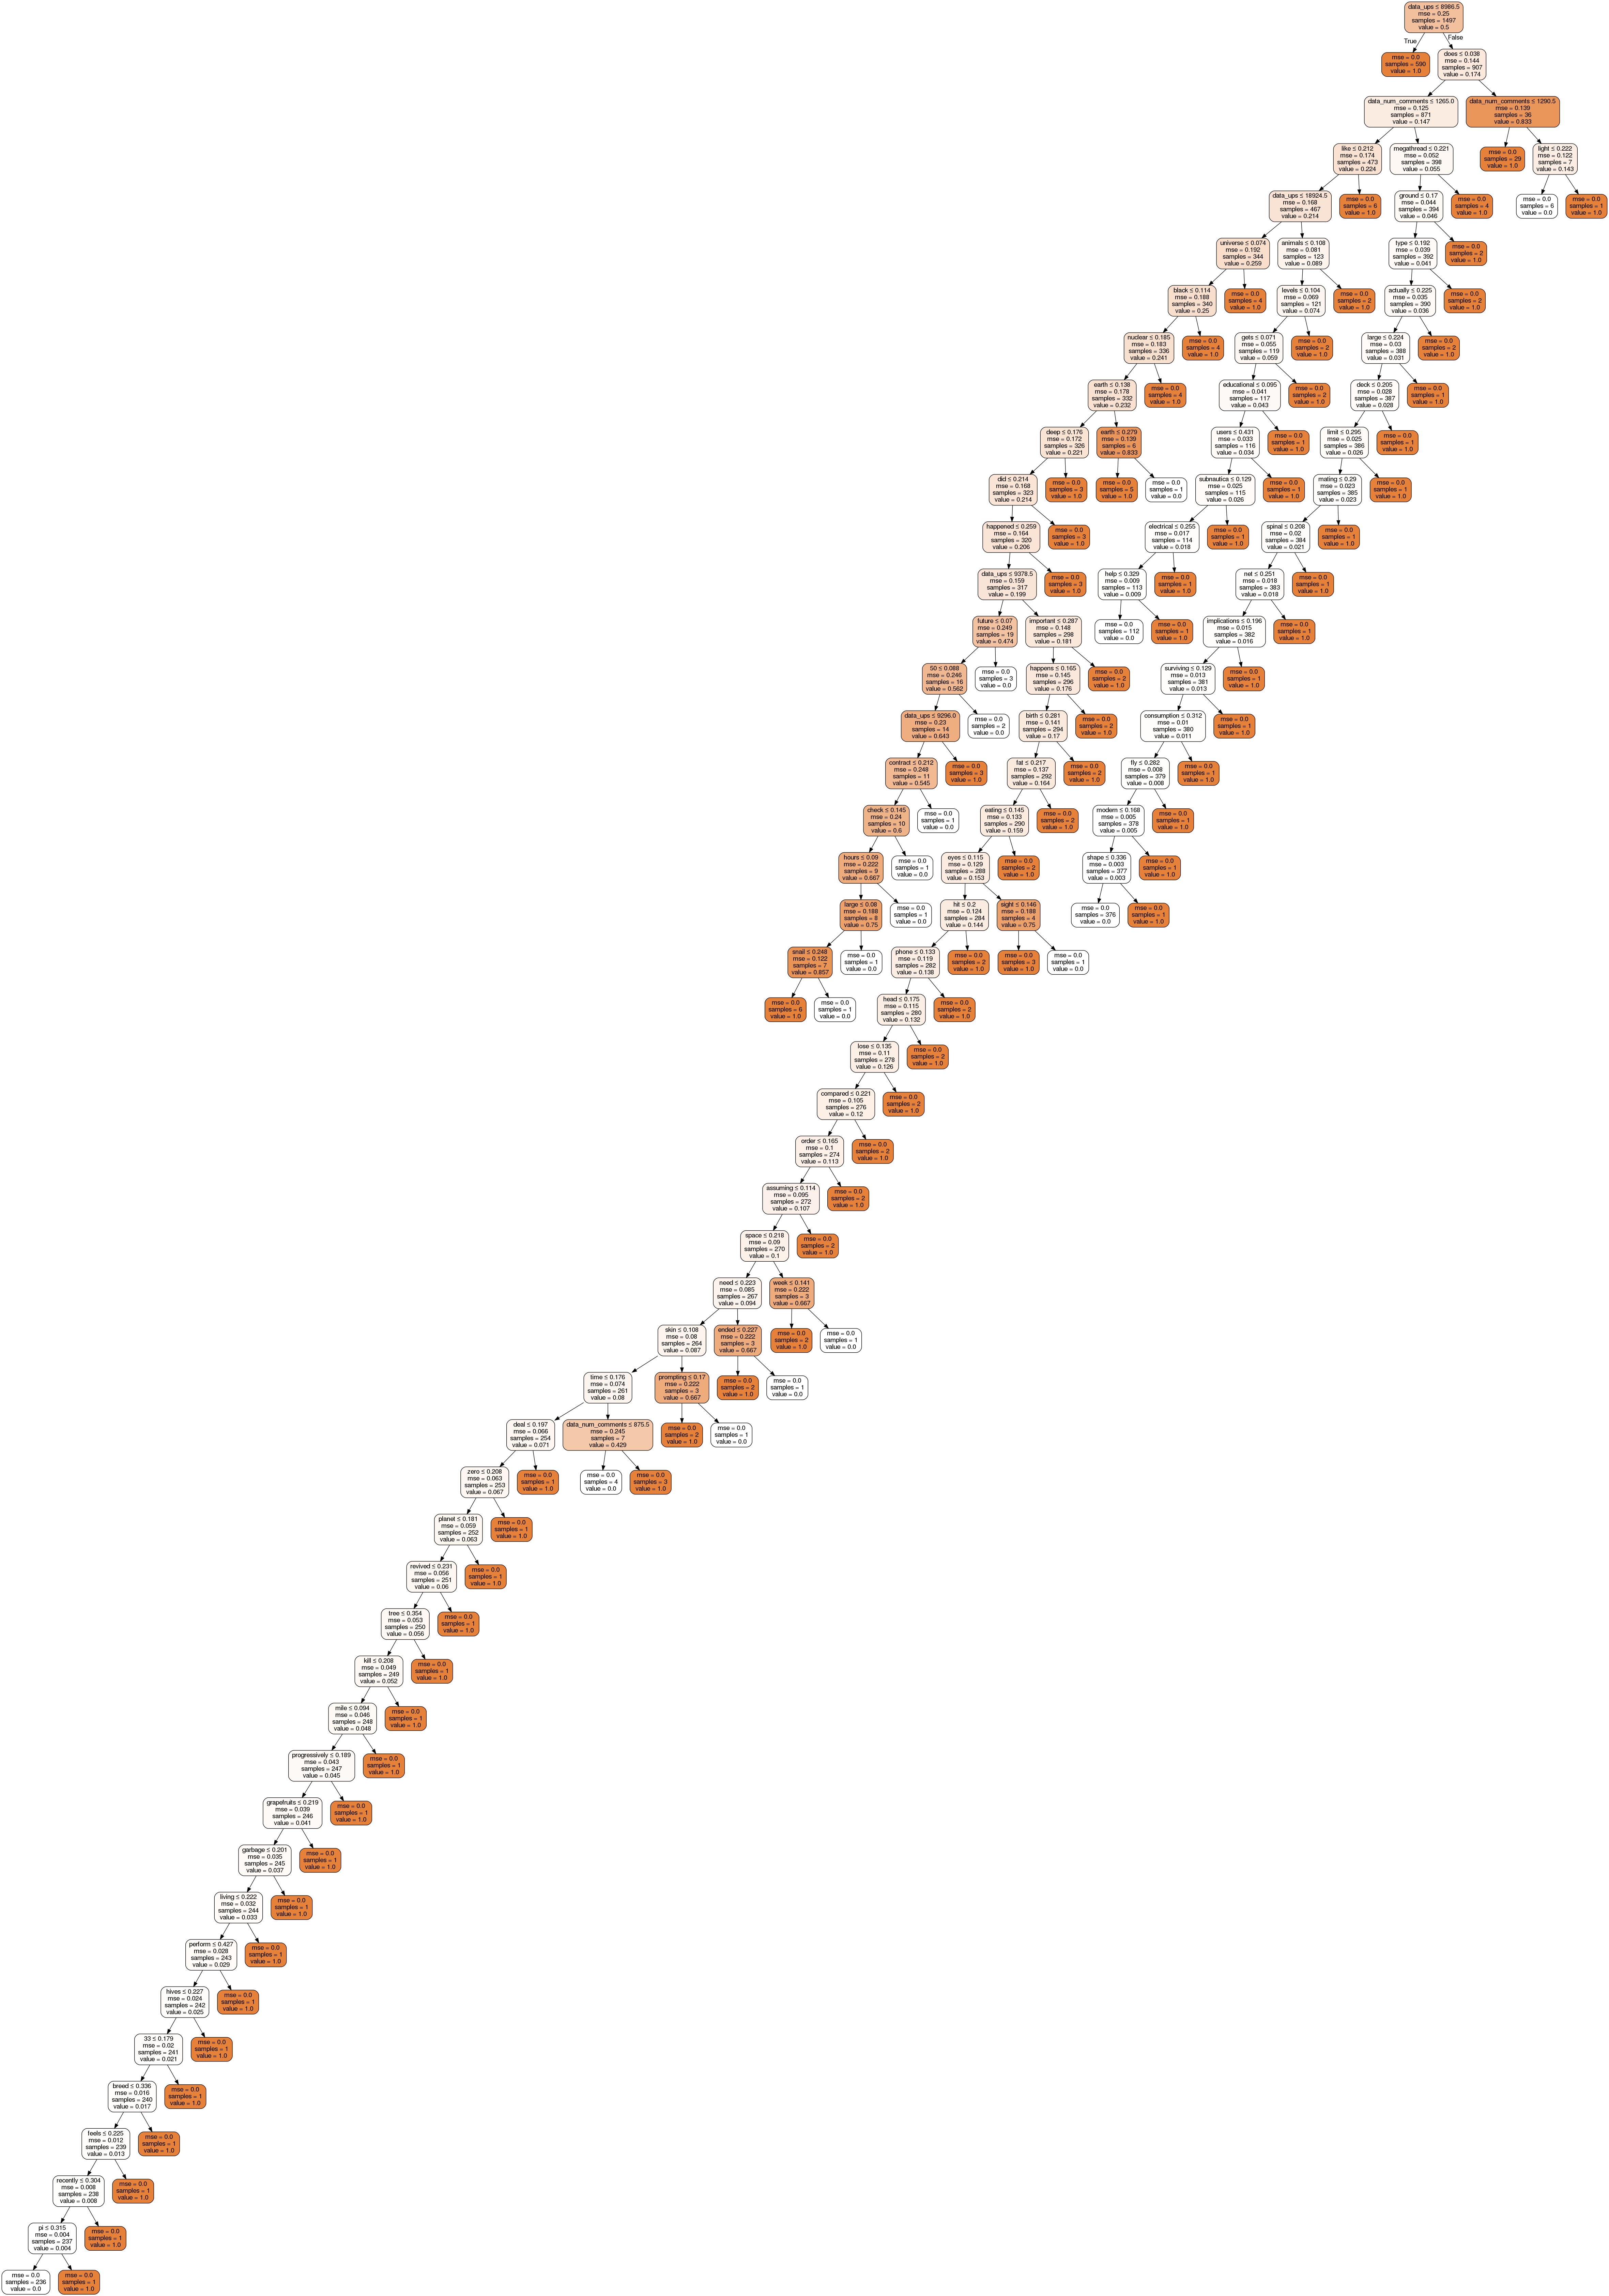

In [44]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = StringIO()  

export_graphviz(
#     gs.best_estimator_, 
    dtr,
    out_file = dot_data,  
    filled=True, rounded=True, proportion=False,
    special_characters=True, 
    feature_names=X.columns
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

**While this is beautiful in a fractal-type way, it is not acceptable for a real NLP application. I will contrain the performance of the tree to only words, not meta data**

Also, I will do a Grid Search for various params to see what works and what doesn't.

In [98]:
X = X.drop(columns = ['data_ups', 'data_num_comments'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [100]:
param_grid = {
    'max_depth' : np.arange(2, 20, 1),
    'min_samples_leaf' : [20, 40, 60, 100], #let's say 1%-5% of the data
    'min_samples_split': [100, 125, 150, 175, 200] # let's say 5% to 10% of the data
}
gs = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, n_jobs=4)

In [101]:
gs.fit(X_train, y_train) #this takes a very long time to train

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'min_samples_leaf': [20, 40, 60, 100], 'min_samples_split': [100, 125, 150, 175, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=125, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [103]:
gs.best_params_

{'max_depth': 13, 'min_samples_leaf': 20, 'min_samples_split': 125}

In [104]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.29381200623607007
0.2710994041698347


^^ This is less overfit, but it is less than the baseline accuracy which would just be 50%

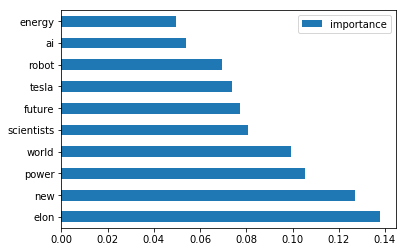

In [105]:
# plot the best estimates

# len(gs.best_estimator_.feature_importances_)

feat_importance_gs = pd.DataFrame(gs.best_estimator_.feature_importances_, X.columns, columns = ['importance'])

feat_importance_gs.sort_values('importance', ascending=False).head(10).plot(kind='barh')

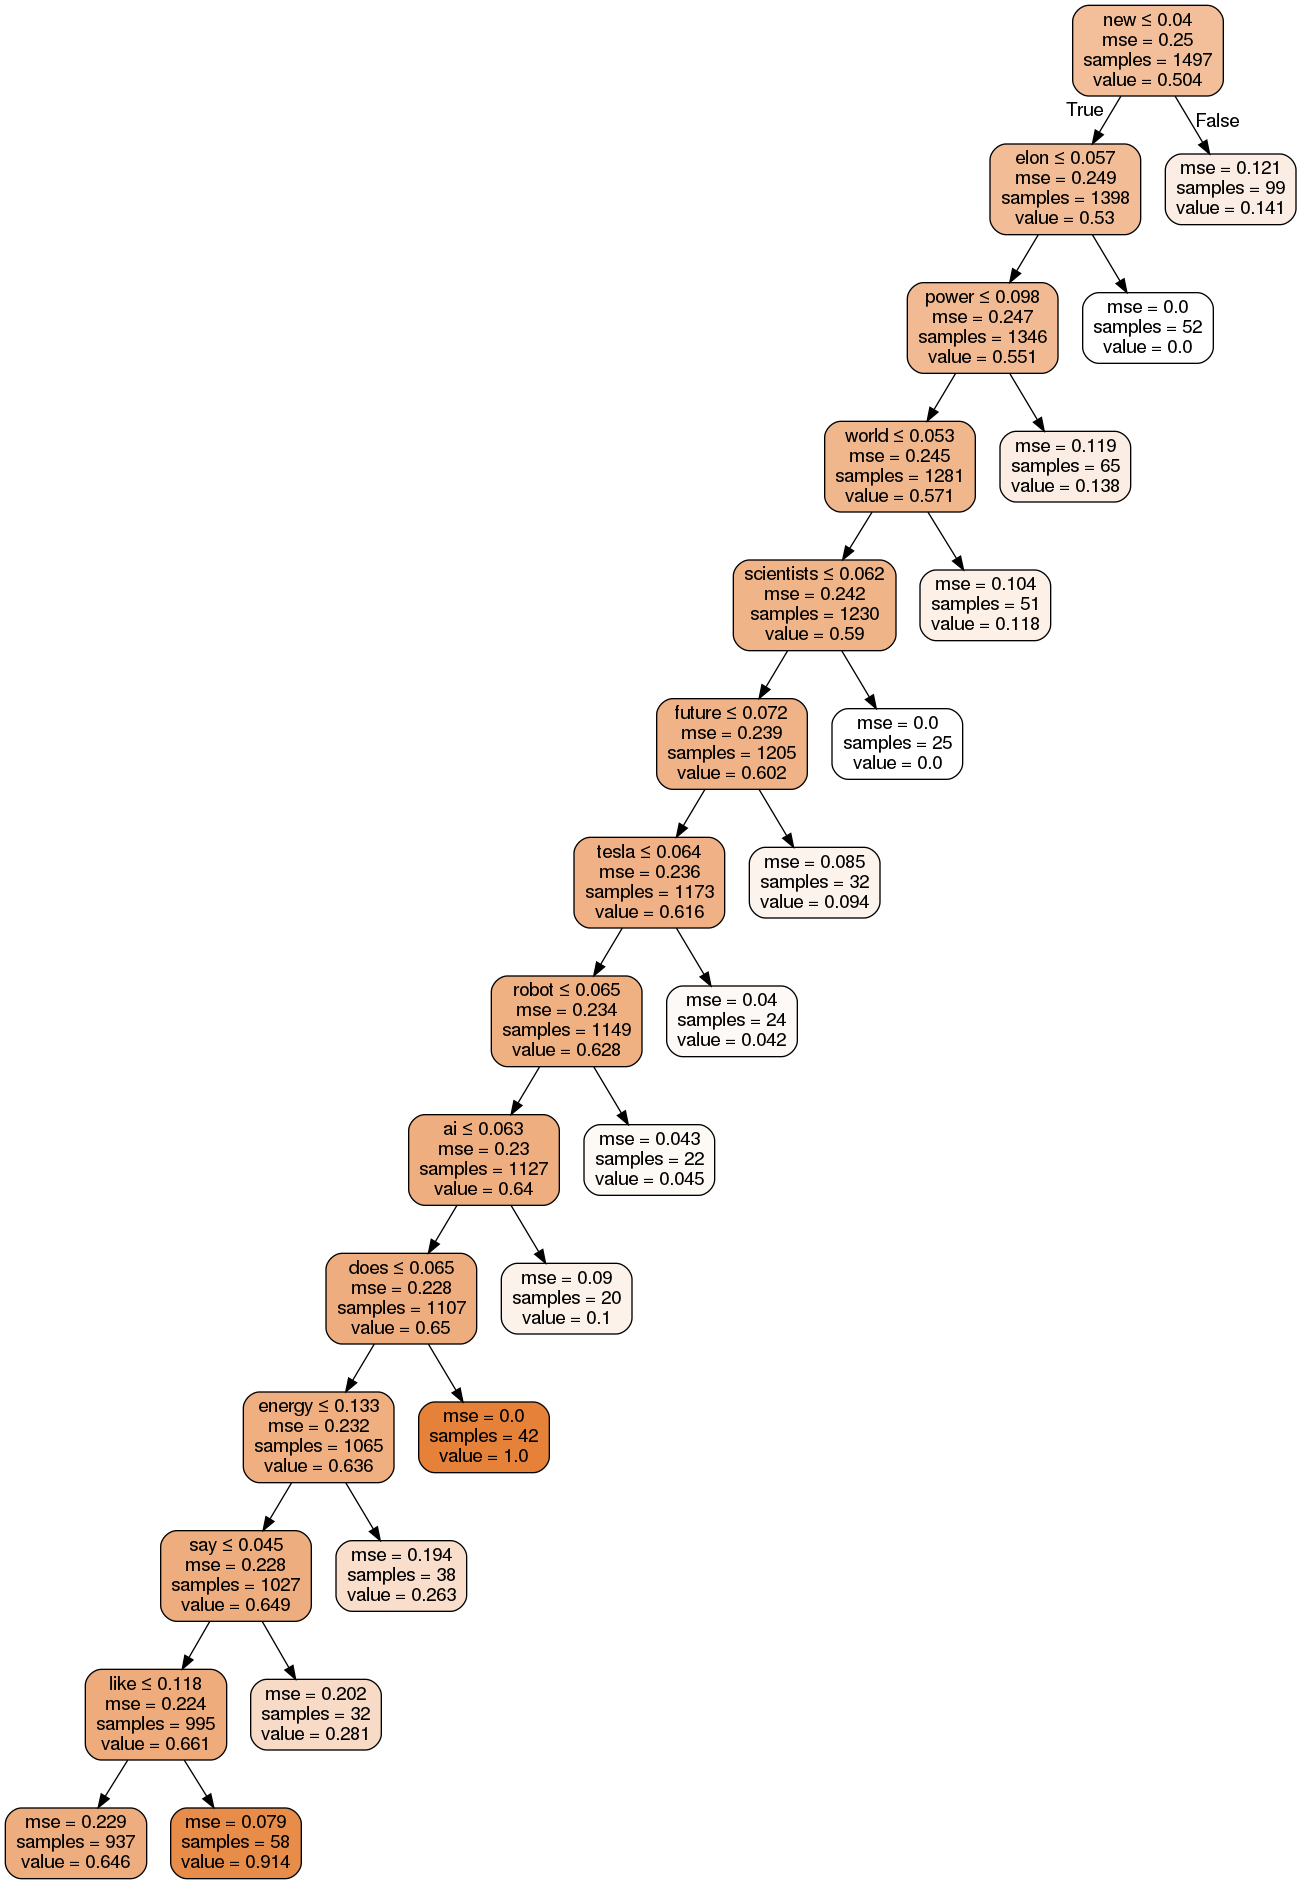

In [106]:
dot_data = StringIO()  

export_graphviz(
#     gs.best_estimator_, 
    gs.best_estimator_,
    out_file = dot_data,  
    filled=True, rounded=True, proportion=False,
    special_characters=True, 
    feature_names=X.columns
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## Ok, the Decision tree was pretty bad.
 **What other models can we try?**
 1. Naive Bayes
 2. Logistic Regression
 3. Ensemble Methods
     - Bagging
     - Boosting

In [113]:
nb= MultinomialNB()

cross_val_score(nb, X_train, y_train).mean() #returns .87

nb.fit(X_train, y_train)
print('train score:', nb.score(X_train, y_train))
print('test score:', nb.score(X_test, y_test))

# Not bad, let's try to grid search to optimize. Update: minimal improvements
nb_params = {
    'alpha': [0.4, 0.5, 0.8, 1]
}
nb_grid = GridSearchCV(MultinomialNB(), param_grid=nb_params, cv=6, n_jobs=4)
nb_grid.fit(X_train, y_train)
print(nb_grid.score(X_train, y_train), nb_grid.score(X_test, y_test))
print(nb_grid.best_estimator_)

train score: 0.9806279225116901
test score: 0.8817635270541082
0.9806279225116901 0.8817635270541082
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)


In [121]:
myd= dict(zip(X_train.columns, list(nb.coef_)[0]))

# to get a clue as to what's going on with NB, let's look at the coefs. The smallest magnitude words are the most
# distinguishing

sorted(myd.items(), key= lambda x: abs(x[1]))[:10]

In [131]:
logreg = LogisticRegressionCV(Cs= 25, cv=10, n_jobs= 7)

# print("cross val score:",cross_val_score(nb, X_train, y_train).mean()) 

logreg.fit(X_train, y_train)
print('train score:', logreg.score(X_train, y_train))
print('test score:', logreg.score(X_test, y_test))
# The accuracy here is pretty high, but there is evidence of overfitting as well


train score: 0.9946559786239145
test score: 0.9018036072144289


In [135]:
myd= dict(zip(X_train.columns, list(logreg.coef_)[0]))

# same concept as with the Naive Bayes

sorted(myd.items(), key= lambda x: abs(x[1]), reverse=True)[:10]

[('new', -3.1450165178935094),
 ('scientists', -3.039958471950898),
 ('world', -3.0127211472717748),
 ('elon', -2.8335275094228103),
 ('musk', -2.7929730711698393),
 ('does', 2.684392729303348),
 ('future', -2.672286333450048),
 ('tesla', -2.6451575522121207),
 ('robot', -2.54283765470185),
 ('power', -2.483457564243172)]

In [137]:
#Ensembel Methods: (naive)
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()


In [138]:
ada.fit(X_train, y_train)
rf.fit(X_train, y_train)
gboost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [139]:
# All these naive implementations are overfit, the random forest is getting low bias, though
print(ada.score(X_train, y_train),ada.score(X_test, y_test))
print(rf.score(X_train, y_train),rf.score(X_test, y_test))
print(gboost.score(X_train, y_train),gboost.score(X_test, y_test))

0.8851035404141616 0.8356713426853707
0.9946559786239145 0.875751503006012
0.9031396125584502 0.8376753507014028


In [145]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.9064796259185037
0.8476953907815631


# START FROM HERE

In [158]:
gb_params={
    'learning_rate': [.19, .2, .22],
#     'max_depth': np.arange(1,9, 1),
    'n_estimators': [55, 60, 70]
}
gb_grid= GridSearchCV(GradientBoostingClassifier(subsample=.8), gb_params, n_jobs=7, cv=5)
gb_grid.fit(X_train, y_train)
print(gb_grid.score(X_train, y_train), gb_grid.score(X_test, y_test))
print(gb_grid.best_estimator_)

0.9171676686706747 0.8537074148296593
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.19, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)


In [159]:
gb_grid.grid_scores_, gb_grid.best_params_, gb_grid.best_score_

/home/omar/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84235, std: 0.01022, params: {'learning_rate': 0.19, 'n_estimators': 55},
  mean: 0.84836, std: 0.00827, params: {'learning_rate': 0.19, 'n_estimators': 60},
  mean: 0.83834, std: 0.00977, params: {'learning_rate': 0.19, 'n_estimators': 70},
  mean: 0.83567, std: 0.01247, params: {'learning_rate': 0.2, 'n_estimators': 55},
  mean: 0.83768, std: 0.01022, params: {'learning_rate': 0.2, 'n_estimators': 60},
  mean: 0.84302, std: 0.01104, params: {'learning_rate': 0.2, 'n_estimators': 70},
  mean: 0.84436, std: 0.01303, params: {'learning_rate': 0.22, 'n_estimators': 55},
  mean: 0.84636, std: 0.00918, params: {'learning_rate': 0.22, 'n_estimators': 60},
  mean: 0.84502, std: 0.01433, params: {'learning_rate': 0.22, 'n_estimators': 70}],
 {'learning_rate': 0.19, 'n_estimators': 60},
 0.8483633934535738)

In [162]:
# After some grid searching, I'll pick learning_rate=.18 and n_estimators= 60
gb_params2={
#     'learning_rate': [.15, .17, .2],
    'max_depth': np.arange(5,16, 3),
    'min_samples_split': [.005, .01, .02]
#     'n_estimators': [30, 40]#, 70]
}
gb_grid2= GridSearchCV(GradientBoostingClassifier(learning_rate=.19, n_estimators=40, 
                                                 subsample=.8),
                      gb_params2, n_jobs=7, cv=5)
gb_grid2.fit(X_train, y_train)
print(gb_grid2.score(X_train, y_train), gb_grid2.score(X_test, y_test))
print(gb_grid2.best_estimator_)

0.9652638610554443 0.8517034068136272
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.19, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=0.005,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)


In [163]:
gb_grid2.grid_scores_, gb_grid2.best_params_, gb_grid2.best_score_

/home/omar/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83968, std: 0.00874, params: {'max_depth': 5, 'min_samples_split': 0.005},
  mean: 0.83901, std: 0.01303, params: {'max_depth': 5, 'min_samples_split': 0.01},
  mean: 0.84302, std: 0.01113, params: {'max_depth': 5, 'min_samples_split': 0.02},
  mean: 0.85304, std: 0.01448, params: {'max_depth': 8, 'min_samples_split': 0.005},
  mean: 0.84502, std: 0.01581, params: {'max_depth': 8, 'min_samples_split': 0.01},
  mean: 0.84569, std: 0.01437, params: {'max_depth': 8, 'min_samples_split': 0.02},
  mean: 0.84636, std: 0.00872, params: {'max_depth': 11, 'min_samples_split': 0.005},
  mean: 0.84836, std: 0.01365, params: {'max_depth': 11, 'min_samples_split': 0.01},
  mean: 0.84436, std: 0.01146, params: {'max_depth': 11, 'min_samples_split': 0.02},
  mean: 0.84502, std: 0.01797, params: {'max_depth': 14, 'min_samples_split': 0.005},
  mean: 0.84903, std: 0.01036, params: {'max_depth': 14, 'min_samples_split': 0.01},
  mean: 0.84970, std: 0.01147, params: {'max_depth': 14, 'min_sampl

In [142]:
ada_params={
    'n_estimators': [66, 70, 77],
#     'learning_rate': [.8, .9, 1.0]
}
ada_grid= GridSearchCV(AdaBoostClassifier(), ada_params, n_jobs=7, cv=8)
ada_grid.fit(X_train, y_train)
print(ada_grid.score(X_train, y_train), ada_grid.score(X_test, y_test))
print(ada_grid.best_estimator_)

0.9091516366065464 0.8376753507014028
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=70, random_state=None)


In [143]:
rf_params={
    'n_estimators': [8, 10, 13, 20],
#     'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1,20, 2),
    'min_samples_leaf': [.01, .04, .05],
    'min_samples_split': [.05, .08, .1],
#     'learning_rate': [.8, .9, 1.0]
}
rf_grid= GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=7, cv=8)
rf_grid.fit(X_train, y_train)
print(rf_grid.score(X_train, y_train), rf_grid.score(X_test, y_test))
print(rf_grid.best_estimator_)

0.6967267869071476 0.7014028056112225
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.01, min_samples_split=0.05,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
